In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset,random_split
import torch.nn.functional as F
import time
import os
import re
from itertools import chain
from transformers import BertTokenizer, BertForMaskedLM
from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

PRETRAINED_MODEL_NAME = "bert-base-chinese" #英文pretrain(不區分大小寫)
print(torch.__version__)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-pack

1.7.0


In [2]:
# get pre-train tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
vocab = tokenizer.vocab
print("dict size", len(vocab))

# see some token and index mapping
import random
random_tokens = random.sample(list(vocab), 10)
random_ids = [vocab[t] for t in random_tokens]

print("{0:20}{1:15}".format("token", "index"))
print("-" * 25)
for t, id in zip(random_tokens, random_ids): #隨便看幾個字
    print("{0:15}{1:10}".format(t, id))

dict size 21128
token               index          
-------------------------
珅                    4393
##捺                 16007
##wa                 9161
##冕                 14146
##姪                 15065
##share             11042
25000               13251
掛                    2965
断                    3171
##鸿                 20953


In [86]:
train = pd.read_csv('train.csv')
val = pd.read_csv('validation.csv')
total = pd.concat([train, val])
total = total.reset_index(drop=True)
total_0 = total[total["Label"] == 0]
total_1 = total[total["Label"] == 1]

In [87]:
total_1

,Content,Label
11,不知道為什麼最近一直很想上吊可能是找不到工作可能是人際讓我不行可能是學業上的困難不知道欸感覺...,1
17,我四月~八月都處於超憂鬱的狀態一直有想死的念頭但八月開始，我一直處於很興奮的狀態，也不較不會...,1
25,十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不...,1
38,前幾天有試過離開但可能方法不對吧感覺還是會有痛苦存在突然有點羨幕那種在睡夢中昏迷且死亡的--...,1
55,活著好累，著手計畫一切，五個月，把所有痛苦不甘一次解決現在的人到底還有誰有著夢想，其實我們出...,1
...,...,...
1696,像我這樣的人 自殺是遲早的事 我從來沒有覺得有活著真好的時候只是現在還不敢跳樓呵呵 想死也沒勇氣,1
1697,看到原po貼文，真的心有戚戚焉小孩別亂生，基因很可怕的我以後也不打算生小孩，會有罪惡感的生出...,1
1698,好想自殺有人能陪我聊天嗎為什麼就這樣離開我...,1
1699,我生長在一個從小言語霸凌嚴重的家庭，從幼稚園回去與他們同住，爸爸每天喝醉，凌晨把我挖醒，辱罵...,1


In [216]:
# Label_1
num_1 = total_1.shape[0]
random_1 = random.sample(range(num_1), num_1)
train_1 = total_1.iloc[random_1[:211]]
test_1 = total_1.iloc[random_1[211:234]]
# Label_0
num_0 = total_0.shape[0]
random_0 = random.sample(range(num_0), num_0)
train_0 = total_0.iloc[random_0[:270]]
test_0 = total_0.iloc[random_0[270:300]]
# train_val_1
train_val_1 = train_1.shape[0]
random_train_val = random.sample(range(train_val_1), train_val_1)
train__1 = train_1.iloc[random_train_val[:148]]
val_1 = train_1.iloc[random_train_val[148:211]]
# train_val_0
train_val_0 = train_0.shape[0]
random_train_val = random.sample(range(train_val_0), train_val_0)
train__0 = train_0.iloc[random_train_val[:189]]
val_0 = train_0.iloc[random_train_val[189:270]]
# train_val
train = pd.concat([train__1, train__0])
train = train.reset_index(drop=True)
val = pd.concat([val_1, val_0])
val = val.reset_index(drop=True)
# test
test = pd.concat([test_1, test_0])
test = test.reset_index(drop=True)

In [217]:
def toList(data):
    df = []
    for j in range(len(data)):
        index = []
        index.append(data.iloc[j]['Content'])
        index.append(data.iloc[j]['Label'])
        df.append(index)
    return df

In [218]:
train = toList(train)
val = toList(val)
test = toList(test)
test

[['吃了藥還是睡不著，打了這篇文章發洩順便分享一下經驗。身心治療以持續快兩年，抱著好好治病的心情治療，但近日我越來越害怕，看似沒有盡頭的療程、日漸衰敗的身體......都讓我絕望無力.....雖說情緒多在控制下，且在職場上表現跟其他夥伴沒兩樣，甚至許多有夥伴認為與我相處較沒壓力，且喜歡具同理心的我，我還是感到自己在下墜；在濃厚彩妝下的是心悸和胸悶後產生的蒼白，白天能順暢的工作、聽同事朋友談心，淚水卻時常在夜裡莫名潰堤。會接受身心治療是渴望治癒自己，但面對漫長的療程，說實話，我似乎跟醫生撒了謊，當醫生問我想不想自殺時，我說不，但其實心裡已有好多次想終結這一切痛苦......',
  1],
 ['已經一段時間沒喝酒了，一次就連喝兩天，不想管明天身體會不會爆掉，受不了的崩潰，好像瞬間就打回原形了，像是，溶化的史萊姆？所有的音樂聽起來都是悲傷，腦海中竄動著那些陳舊的變形的話語，令人想吐。怎麼能夠這麼噁心？這麼令人失望的人，是我嗎？最令人想吐的就是我自己。是不是要挖出自己的眼睛，割掉自己的耳朵，把皮膚吋吋割裂，才能得到平靜？在腦海中自殘一百次，只要沒有真的動手，就不算真的自殘，就不會被發現。她說：「都是為了你們。」他說：「你知道你做了什麼嗎？」她說：「你們這些自私的人。」他說：「你怎麼這麼賤。」她說：「你不能再忍耐嗎？」他說：「這一切都是你破壞的。」但是她哭了，他也哭了是我的錯吧......我做得不夠好把蓋子蓋起來也沒有用，把蓋子打開也沒有用，到底該如何是好？今天他說偶爾也會對生活感覺到厭倦，我腦海中閃過的是，那就一起死吧。可是仔細想想，想死的可能只有我，他不過是微感厭倦而已，這麼想的我實在太有病了。又哭了好久，好想好想他，真想立刻飛到他身邊，躲在他身後永遠不要醒來。--',
  1],
 ['我的悲傷來源我很想死 但我想先把他殺死再自殺 不虧 所以他怎麼還不死', 1],
 ['這樣也不對那樣也不對是不是我去死全世界才高興我要od了，晚安--', 1],
 ['我的努力還不夠嗎？我自認為一直以來我都很努力活著，從小到大都是，我一直都很努力朝著社會期許、家人的期許去做，我拼了命控制花費，我爸根本沒看見，只認為是理所當然，他知道我付出多少代價嗎？我努力得還不夠嗎？為什麼沒有辦法做到飲食控制、沒有辦法順利繼續減重？我努力得不夠嗎？我用花精，只為了讓自己更平靜，又有誰懂？我努力

In [179]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df #its list [['text1',label],['text2',label],...]
        self.len = len(self.df)
#         self.maxlen = 300 #限制文章長度(若你記憶體夠多也可以不限)
        self.tokenizer = tokenizer  # we will use BERT tokenizer
        
    def __getitem__(self, idx):
        origin_text = self.df[idx][0]
        text_a = self.df[idx][0]
        text_b = None  #for natural language inference
        #label_tensor = None #in our case, we have label
        label_id = self.df[idx][1]
        label_tensor = torch.tensor(label_id)
        
        # 建立第一個句子的 BERT tokens
        word_pieces = ["[CLS]"]
        tokens_a = self.tokenizer.tokenize(text_a)
        word_pieces += tokens_a[:self.len] + ["[SEP]"]
        len_a = len(word_pieces)
        
        if text_b is not None:
            tokens_b = self.tokenizer.tokenize(text_b)
            word_pieces += tokens_b + ["[SEP]"]
            len_b = len(word_pieces) - len_a
            
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
        if text_b is None:
            segments_tensor = torch.tensor([1] * len_a,dtype=torch.long)
        elif text_b is not None:
            segments_tensor = torch.tensor([0] * len_a + [1] * len_b,dtype=torch.long)
            
        return (tokens_tensor, segments_tensor, label_tensor, origin_text)
    
    def __len__(self):
        return self.len

In [219]:
trainset = MyDataset(train, tokenizer=tokenizer)
valset = MyDataset(val, tokenizer=tokenizer)
testset = MyDataset(test, tokenizer=tokenizer)

In [220]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
""""
create_mini_batch(samples)吃上面定義的mydataset
回傳訓練 BERT 時會需要的 4 個 tensors：
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- segments_tensors: (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""
#collate_fn: 如何將多個樣本的資料連成一個batch丟進 model
#截長補短後要限制attention只注意非pad 的部分
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 訓練集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
        
    # zero pad到該batch下最長的長度
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors,batch_first=True)
    
    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape,dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

# 初始化一個每次回傳 batch size 個訓練樣本的 DataLoader
# 利用 'collate_fn' 將 list of samples 合併成一個 mini-batch
BATCH_SIZE = 91
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch,shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch,shuffle=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch,shuffle=False)

data = next(iter(trainloader))
tokens_tensors, segments_tensors, masks_tensors, label_ids = data
print(tokens_tensors)
print(segments_tensors)
print(masks_tensors)
print(label_ids)

tensor([[ 101, 6857, 2407,  ...,    0,    0,    0],
        [ 101,  791, 1921,  ...,    0,    0,    0],
        [ 101, 1071, 2179,  ..., 2156, 1168,  102],
        ...,
        [ 101, 3297, 6818,  ...,    0,    0,    0],
        [ 101, 1728, 4158,  ..., 3297, 1044,  102],
        [ 101, 1333, 3315,  ..., 2595, 8024,  102]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1

## Visualization

In [226]:
# 安裝 BertViz
import sys
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1077 (delta 0), reused 2 (delta 0), pack-reused 1074
Receiving objects: 100% (1077/1077), 100.00 MiB | 18.23 MiB/s, done.
Resolving deltas: 100% (687/687), done.


In [227]:
# import packages
from transformers import BertTokenizer, BertModel
from bertviz import head_view

In [228]:
# 在 jupyter notebook 裡頭顯示 visualzation 的 helper
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

clear_output()

## model

In [221]:
from transformers import BertForSequenceClassification

NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)


print("""
name      module
--------------------""")

for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print("{:10}{}".format(name,n) )
    else:
        print("{:10} {}".format(name, module))

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


name      module
--------------------
bert      embeddings
bert      encoder
bert      pooler
dropout    Dropout(p=0.1, inplace=False)
classifier Linear(in_features=768, out_features=2, bias=True)


In [222]:
## fine-tunning
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 21128
}

In [223]:
%%time
from sklearn.metrics import accuracy_score

from collections import defaultdict
history = defaultdict(list)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
model = model.to(device)

# 使用 Adam Optim 更新整個分類模型的參數
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
EPOCHS = 10
# 訓練模式
model.train()

for epoch in range(EPOCHS):
    correct = 0
    #total = 0
    train_loss , val_loss = 0.0 , 0.0
    train_acc, val_acc = 0, 0
    n, m = 0, 0
    
    for data in trainloader:
        n += 1
        tokens_tensors, segments_tensors,masks_tensors, labels = [t.to(device) for t in data]

        # 將參數梯度歸零
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        # outputs 的順序是 "(loss), logits, (hidden_states), (attentions)"
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        
        #get prediction and calulate acc
        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc += accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        # 紀錄當前 batch loss
        train_loss += loss.item()
    
    #validation
    with torch.no_grad():
        model.eval()
        for data in valloader:
            m += 1
            tokens_tensors, segments_tensors,masks_tensors, labels = [t.to(device) for t in data]
            val_outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
            
            logits = val_outputs[1]
            _, pred = torch.max(logits.data, 1)
            val_acc += accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())
            val_loss += val_outputs[0].item()
            
    history['train_acc'].append(train_acc/n)
    history['train_loss'].append(train_loss/n)
    history['val_acc'].append(val_acc/m)
    history['val_loss'].append(val_loss/m)

    print('[epoch %d] loss: %.4f, acc: %.4f, val loss: %4f, val acc: %4f' %
          (epoch+1, train_loss/n, train_acc/n, val_loss/m,  val_acc/m  ))

print('Done')

device: cpu
[epoch 1] loss: 0.6837, acc: 0.5464, val loss: 0.643685, val acc: 0.619117
[epoch 2] loss: 0.6091, acc: 0.7060, val loss: 0.624084, val acc: 0.655194
[epoch 3] loss: 0.5372, acc: 0.8012, val loss: 0.600809, val acc: 0.674062
[epoch 4] loss: 0.4666, acc: 0.8354, val loss: 0.613255, val acc: 0.663798
[epoch 5] loss: 0.3959, acc: 0.8797, val loss: 0.584114, val acc: 0.721957
[epoch 6] loss: 0.3219, acc: 0.9017, val loss: 0.611643, val acc: 0.685776
[epoch 7] loss: 0.2604, acc: 0.9505, val loss: 0.580628, val acc: 0.719573
[epoch 8] loss: 0.1922, acc: 0.9780, val loss: 0.595033, val acc: 0.726622
[epoch 9] loss: 0.1395, acc: 0.9906, val loss: 0.634886, val acc: 0.695936
[epoch 10] loss: 0.1070, acc: 0.9894, val loss: 0.610063, val acc: 0.750985
Done
CPU times: user 4h 28min 12s, sys: 2h 43min 56s, total: 7h 12min 9s
Wall time: 20min 25s


In [196]:
history

defaultdict(list,
            {'train_acc': [0.584950206043956,
              0.7318853021978022,
              0.8043440934065934,
              0.8604481456043956,
              0.9028159340659341,
              0.947501717032967,
              0.9807692307692308,
              0.9945054945054945,
              0.9945054945054945,
              0.99609375],
             'train_loss': [0.6840049475431442,
              0.598485454916954,
              0.5052871853113174,
              0.40017686784267426,
              0.32042694836854935,
              0.22931243106722832,
              0.15751192718744278,
              0.11415546014904976,
              0.08696795254945755,
              0.0703355148434639],
             'val_acc': [0.7212315985900892,
              0.7313912502591748,
              0.7809454696247149,
              0.706199460916442,
              0.7557536802819822,
              0.7643582832262078,
              0.7926601700186606,
              0.78478125647936

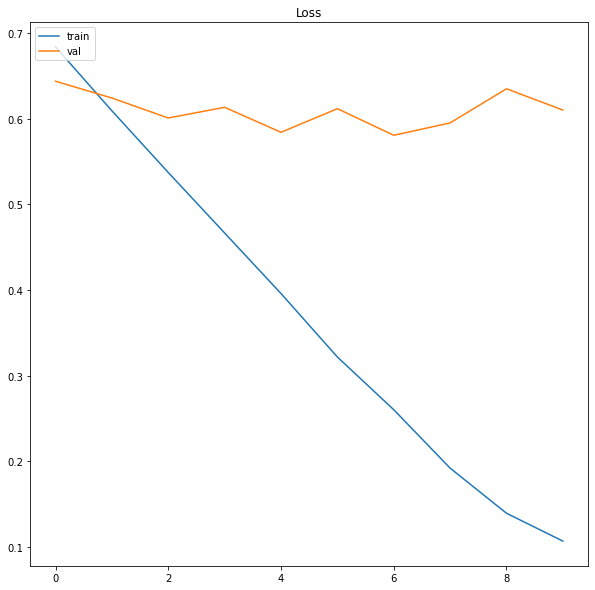

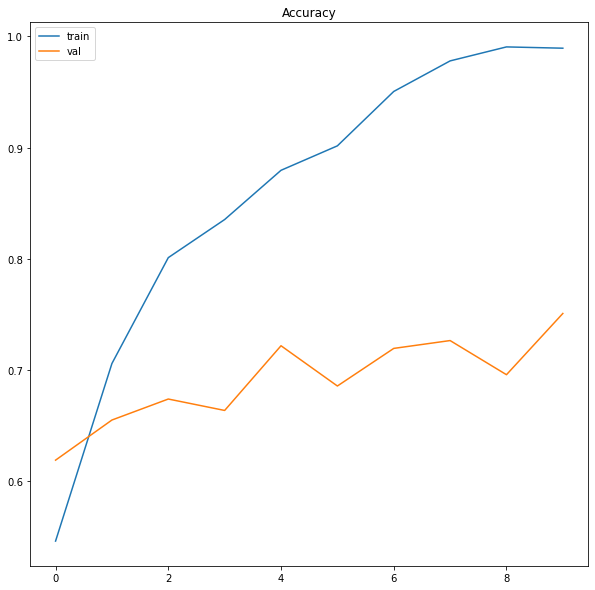

In [224]:
plt.figure(figsize=(10, 10))
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

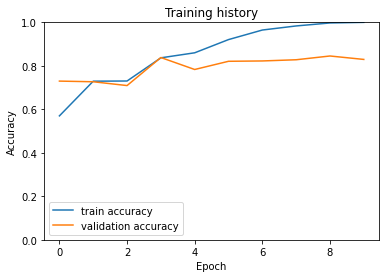

In [187]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [44]:
torch.save(model, 'bert_514.h5')

In [161]:
torch.save(model.state_dict(), 'bert_534.h5')

In [29]:
model = torch.load('bert_440.h5')

In [225]:
from sklearn.metrics import confusion_matrix, classification_report

true=[]
predictions=[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        tokens_tensors, segments_tensors,masks_tensors, labels = [t.to(device) for t in data]
        val_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors, 
                    labels=labels)

        logits = val_outputs[1]
        _, pred = torch.max(logits.data, 1)
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())


c = confusion_matrix(true, predictions)
print(c)
print('Accuracy Score: ', accuracy_score(true, predictions), '\n')

matrix = classification_report(true, predictions,labels=[1,0])
print('Classification report : \n', matrix)

[[15 15]
 [ 3 20]]
Accuracy Score:  0.660377358490566 

Classification report : 
               precision    recall  f1-score   support

           1       0.57      0.87      0.69        23
           0       0.83      0.50      0.62        30

    accuracy                           0.66        53
   macro avg       0.70      0.68      0.66        53
weighted avg       0.72      0.66      0.65        53



In [97]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.8        0.2       ]
 [0.47826087 0.52173913]]


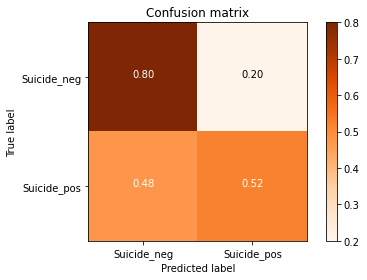

In [175]:
target_names = [ 'Suicide_neg','Suicide_pos']

plt.figure()
cnf_matrix = confusion_matrix(true, predictions)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True)

plt.show()

In [ ]:
# torch.cuda.get_device_name(0)

In [82]:
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl

<Figure size 432x288 with 0 Axes>

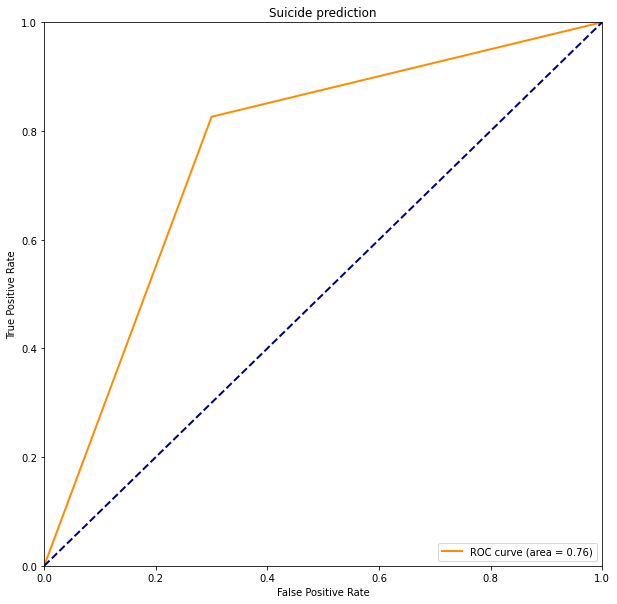

In [199]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(true, predictions) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
 # In[*]
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率爲橫座標，真正率爲縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Suicide prediction')
plt.legend(loc="lower right")
plt.show()

## Save history

In [154]:
dict = {'train_acc': [0.5447716346153846,
              0.6160714285714286,
              0.6558207417582417,
              0.746351304945055,
              0.7800480769230769,
              0.7839543269230769,
              0.8361521291208791,
              0.8572716346153846,
              0.8808379120879121,
              0.9211881868131868],
             'train_loss': [0.7237949073314667,
              0.6564912050962448,
              0.616296797990799,
              0.5716355293989182,
              0.5331272780895233,
              0.49375946819782257,
              0.4342891350388527,
              0.39523038268089294,
              0.3408505246043205,
              0.27421779930591583],
             'val_acc': [0.6538461538461539,
              0.6661828737300435,
              0.6566452415509019,
              0.712523325730873,
              0.7101389176860875,
              0.7014306448268712,
              0.715633423180593,
              0.6998755961020111,
              0.7250673854447439,
              0.7069251503213767],
             'val_loss': [0.642042487859726,
              0.6344656348228455,
              0.636645644903183,
              0.5841412246227264,
              0.5620448291301727,
              0.5697548389434814,
              0.5322308838367462,
              0.5504950433969498,
              0.5220378637313843,
              0.5853040963411331]}
dict['true'] = true
dict['predictions'] = predictions
dict['train'] = train
dict['val'] = val
dict['test'] = test
f = open("bert_534.txt","w")
f.write( str(dict) )
f.close()

In [155]:
import ast
with open('bert_534.txt') as f:
    contents = f.read()
    dictionary = ast.literal_eval(contents)
    print(type(dictionary))
    print(dictionary)

<class 'dict'>
{'train_acc': [0.5447716346153846, 0.6160714285714286, 0.6558207417582417, 0.746351304945055, 0.7800480769230769, 0.7839543269230769, 0.8361521291208791, 0.8572716346153846, 0.8808379120879121, 0.9211881868131868], 'train_loss': [0.7237949073314667, 0.6564912050962448, 0.616296797990799, 0.5716355293989182, 0.5331272780895233, 0.49375946819782257, 0.4342891350388527, 0.39523038268089294, 0.3408505246043205, 0.27421779930591583], 'val_acc': [0.6538461538461539, 0.6661828737300435, 0.6566452415509019, 0.712523325730873, 0.7101389176860875, 0.7014306448268712, 0.715633423180593, 0.6998755961020111, 0.7250673854447439, 0.7069251503213767], 'val_loss': [0.642042487859726, 0.6344656348228455, 0.636645644903183, 0.5841412246227264, 0.5620448291301727, 0.5697548389434814, 0.5322308838367462, 0.5504950433969498, 0.5220378637313843, 0.5853040963411331], 'true': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 